<a href="https://colab.research.google.com/github/nafis-neehal/ML_PROJ_RPI/blob/main/HW5/HW5_1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1b: Pretrained Model for CIFAR10 Dataset Classification
In this task, I have used MobilenetV2 pretrained model and finetuned it to perform classification task on CIFAR10. 

# Mount Drive and Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
#https://analyticsindiamag.com/implementing-alexnet-using-pytorch-as-a-transfer-learning-model-in-multi-class-classification/
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from tqdm import tqdm 
import time, copy
import pickle
import seaborn as sns

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

#GPU Test, Load and Preprocess Data, and Sample Show

In [3]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, tf.test.gpu_device_name())

cuda:0 /device:GPU:0


Here I have used simple transformations on the whole data - resized them by upsampling, then croped in the center, transformed them into tensor and then normalized the data. I upsampled the data because MobileNet requires data input size of 224x224. \\
I have then created three separate dataloaders for Train, Validation and Test batches with batch size 4 because of GPU memory issues. \\
I have used CIFAR10 image dataset for this problem. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. We have used validation size of 10% of the training set.

In [4]:
transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

batch_size = 4

train    = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

validation_size = int(train.data.shape[0] * 0.10)
train_size = int(train.data.shape[0] - validation_size)

trainset, validset = torch.utils.data.random_split(train, [train_size,validation_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=4)

testset     = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader  =  torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


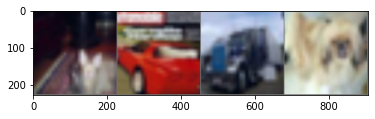

In [5]:
def imgshow(img): 
  im = img.numpy()
  im =  (im - np.min(im))/np.ptp(im) #convert to [0,1] range, float values
  plt.imshow(np.transpose(im,(1,2,0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imgshow(torchvision.utils.make_grid(images))

#Load Pretrained Model and Architecture Change
Here I have loaded the pretrained MobilenetV2 model. In it's last layer it has output size of 1000 because it was originally trained on Imagenet dataset with 1000 classes. I changed the output layer size to 10 as CIFAR10 has 10 classes. This is now the new finetuned network architecture. See the summary below.

In [6]:
num_classes = len(trainset.dataset.classes)
model = torchvision.models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(1280, num_classes)
model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

#Fine tune Pre-trained Model for New Problem
We use the same optimizer and loss as Part 1a for comparison purposes.

In [7]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

We perform the training with 5 epochs. Everytime we train on one batch, we measure the validation score and keep tabs on both losses and accuracies for training and validation. After each 1000 iterations of batches, we check the running average of accuracies and losses and if the model improves on validation set, we then save the model state as the current best model state. After the whole training is done, we reload the saved best model state and evaluate that on training set. We finally then save model history, model best state offline for future use. 

In [8]:
#args = model path, history path
def train_or_load(model, perform, *args):

  if perform=="train":

    best_weights = copy.deepcopy(model.state_dict())
    best_val_acc = 0 
    stat_in_each_batch = 1000
    EPOCHS = 5

    tr_acc_hist   = []
    tr_loss_hist  = []
    val_loss_hist = []
    val_acc_hist  = []

    since = time.time()

    for epoch in range(EPOCHS):  # loop over the dataset multiple times

        tr_running_loss = 0.0
        tr_running_corr = 0

        for i, data in tqdm(enumerate(trainloader)):
            # get the inputs; data is a list of [inputs, labels]
            tr_inputs, tr_labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            tr_outputs = model(tr_inputs)
            loss = criterion(tr_outputs, tr_labels)
            loss.backward()
            optimizer.step()

            # print statistics
            tr_running_loss += loss.item() * tr_inputs.size(0)
            _, tr_preds = torch.max(tr_outputs, 1)
            tr_running_corr += torch.sum(tr_preds==tr_labels.data)

            # #gpu memory clean
            tr_inputs.detach()
            tr_labels.detach()
            tr_outputs.detach()

            if (i+1) % stat_in_each_batch == 0:
              with torch.no_grad():
                v_loss = 0.0
                v_corr = 0
                for j, data in enumerate(validloader):
                  v_inputs, v_labels = data[0].to(device), data[1].to(device)
                  v_outputs = model(v_inputs)
                  loss = criterion(v_outputs, v_labels)

                  _, v_preds = torch.max(v_outputs, 1)
                  v_loss += loss.item() * v_inputs.size(0)
                  v_corr += torch.sum(v_preds==v_labels.data)
              
              #placeholder
              val_acc   = v_corr/len(validloader.dataset)
              tr_acc    = tr_running_corr / (stat_in_each_batch*batch_size) 
              val_loss  = v_loss/len(validloader.dataset)
              tr_loss   = tr_running_loss/(stat_in_each_batch*batch_size)

              #print stat
              print(f"\n Epoch: {epoch} Batch: {(i+1)} Train Loss: {tr_loss} Train Acc: {tr_acc} Val Loss: {val_loss} Val Acc: {val_acc}")
              
              #make sum 0
              tr_running_loss = 0.0
              tr_running_corr = 0

              #save history
              tr_acc_hist.append(tr_acc)
              tr_loss_hist.append(tr_loss)
              val_loss_hist.append(val_loss)
              val_acc_hist.append(val_acc)

              #model state transfer
              if val_acc > best_val_acc:
                best_val_acc = val_acc 
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f}'.format(best_val_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    #history
    tr_acc_hist = [x.cpu().item() for x in tr_acc_hist]
    val_acc_hist = [x.cpu().item() for x in val_acc_hist] 
    history = {"Training Loss": tr_loss_hist, "Training Accuracy": tr_acc_hist, "Validation Loss": val_loss_hist, "Validation Accuracy": val_acc_hist}

    #save model
    torch.save(model.state_dict(), args[0])

    #save history
    with open(args[1], 'wb') as f:
      pickle.dump(history, f)


  elif perform=="load":
    PATH = args[0]
    model.load_state_dict(torch.load(PATH))

    with open(args[1], 'rb') as f:
      history = pickle.load(f)

  return model, history





In [9]:
model_PATH    = './drive/MyDrive/ML Project Course/HW5/cifar_mobilenetV2.pth'
history_PATH  = './drive/MyDrive/ML Project Course/HW5/history_5_1b.pkl'

In [10]:
model, history = train_or_load(model, "load", *[model_PATH, history_PATH])

#Performance Evaluation
For training and validation accuracy we got around 89% and 88% respectively.

## Evaluation on Test Data
On test data we are getting around 87% accuracy. So on all datasources pre-trained model is outperforming our previous CNN model trained in part1a. 

In [11]:
#Test Performance 
with torch.no_grad():
  test_loss = 0.0
  test_correct = 0

  for i, data in tqdm(enumerate(testloader)):
    te_inputs, te_labels = data[0].to(device), data[1].to(device)
    te_outputs = model(te_inputs)
    te_loss = criterion(te_outputs, te_labels)
    test_loss += te_loss.item() * te_inputs.size(0)

    _, te_pred = torch.max(te_outputs.data, 1)
    test_correct += (te_pred == te_labels).sum().item()

print(f"\nTest Loss: {test_loss/len(testloader.dataset):0.05f} Test Accuracy: {test_correct/len(testset):0.05f}")
    

2500it [00:37, 66.44it/s]


Test Loss: 0.36670 Test Accuracy: 0.87710


## Plot History

In [15]:
history.keys()

dict_keys(['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])

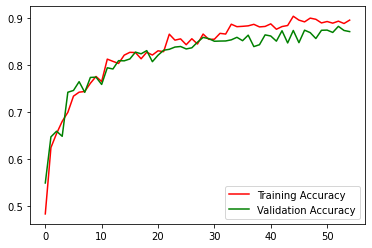

In [16]:
plt.plot(history["Training Accuracy"], label="Training Accuracy", color="red")
plt.plot(history["Validation Accuracy"], label="Validation Accuracy", color="green")
plt.legend()
plt.show()

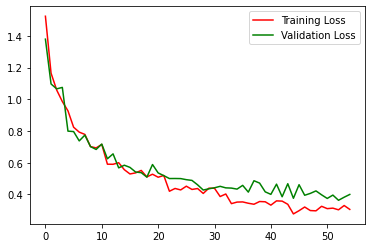

In [17]:
plt.plot(history["Training Loss"], label="Training Loss", color="red")
plt.plot(history["Validation Loss"], label="Validation Loss", color="green")
plt.legend()
plt.show()

##Heatmap

In [18]:
classes = trainset.dataset.classes
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)

In [19]:
with torch.no_grad():
    for images, labels in tqdm(testloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for k in range(len(labels)):
            true_label = labels[k].item()
            predicted_label = predicted[k].item()
            heatmap.iloc[true_label,predicted_label] += 1

100%|██████████| 2500/2500 [00:39<00:00, 62.90it/s]


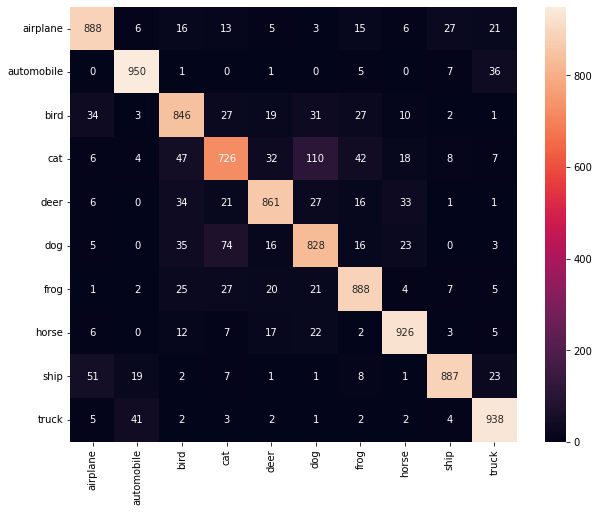

In [20]:
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d")
plt.show()

#Performance comparison with part 1a
So we can see that in part 1a we were getting around 57% accuracy in train, test and validation sets. But for pre-trained MobilenetV2 model we are now getting upto 88% accuracy. Although with proper GPU resources, both model's could have been improved a lot, but still, according to my experimental results along with previous literature supports pre-trained models will always have an edge over the Vanilla CNN models built from Scratch. Performance difference can be visualized for True positives as well in both heatmaps (look at the diagonal values), where these TPs increased a lot more in pre-trained models which leads to higher precision.

Dataset: Cifar10 https://pytorch.org/vision/stable/datasets.html \\
References: 
- https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html 
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html 
- https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html 
- https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html 